#  Analyzing NYC High School Data



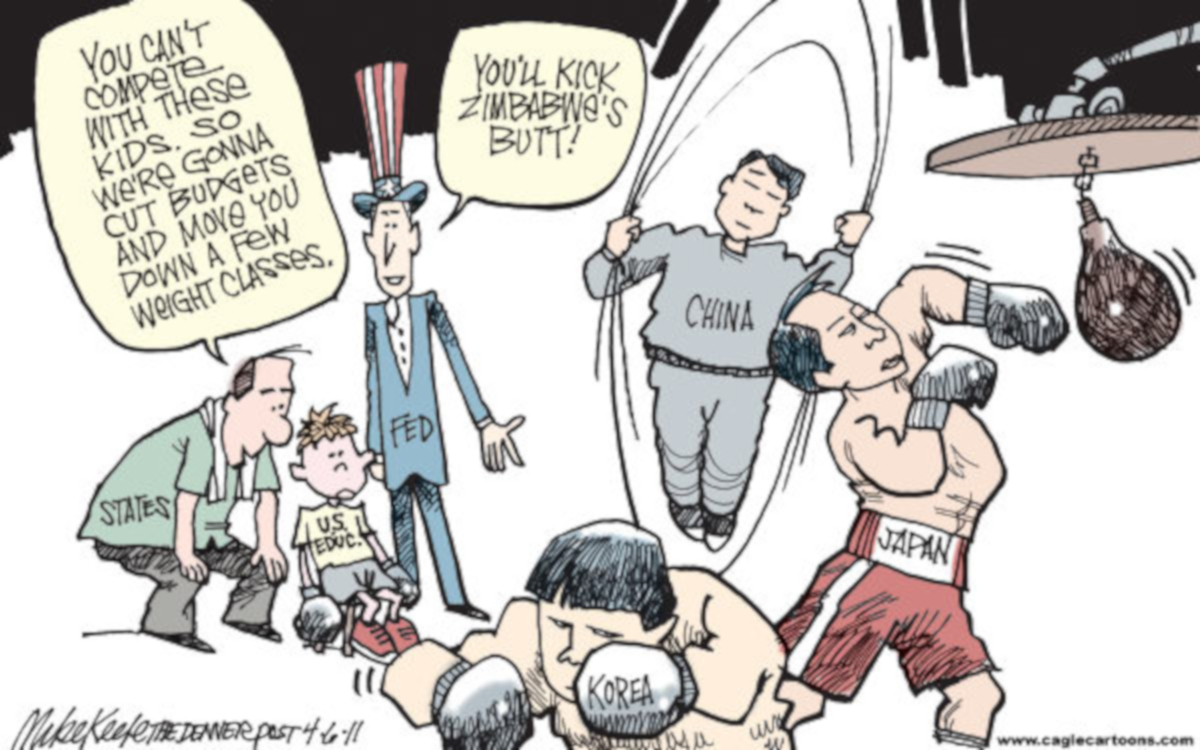

`The primary goal of this project - collect data from different sources and their  combining, analyzing and visualization.` 

The aim of this project looking for relations for SAT score  and  demographic factors such as race, income, and gender with SAT scores.  In the 2011 year  <a href="https://en.wikipedia.org/wiki/SAT" target="_blank">SAT</a>, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points.


New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

* <a href="https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4" target="_blank">SAT scores by school</a> - SAT scores for each high school in New York City
* <a href="https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt" target="_blank">School attendance</a> - Attendance information for each school in New York City
* <a href="https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3" target="_blank">Class size</a> - Information on class size for each school
* <a href="https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e" target="_blank">AP test results</a> - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)

* <a href="https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a" target="_blank">Graduation outcomes</a> - The percentage of students who graduated, and other outcome information

* <a href="https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j" target="_blank">Demographics</a> - Demographic information for each school

* <a href="https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8" target="_blank">School survey</a> - Surveys of parents, teachers, and students at each school


## Read in the data


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Create scv list for import
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Create empty dictionary
data = {}

#Filling data dictionary 
for f in data_files:
    d = pd.read_csv("data/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
#Import data from text files
all_survey = pd.read_csv("data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("data/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# Concatenate by rows
survey = pd.concat([all_survey, d75_survey], axis=0)

# Create new DBN column
survey["DBN"] = survey["dbn"]

# Defile survey column list 
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# Create new colunms in surver
survey = survey.loc[:,survey_fields]
# Import survey to data dictionary
data["survey"] = survey

## Add DBN columns

In [3]:
# Copy existing dbn to new column
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

#Exract character code and fill zero if not exist
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

# Convert CSD    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

# Convert CSD for DBN
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find and print correlations by sat_score column

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
# Print all values for correlations["sat_score"]
print(correlations.to_string())

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# 1. Introduction

## Defenition SAT 2011 score gradations

In 2011 year SAT exam contained three partitions:
* 1. Critical Reading 
* 2. Mathematics
* 3. Writing

The maximal scores for each partition - 800, hence maximal total  SAT score in 2011 year was 3 * 800 = 2 400 scores. The detailed information about SAT Score and percentile for USA colleges you can download <a href="https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Percentile-Ranks-Composite-CR-M-W-2011.pdf" target="_blank">here.</a>

Modern gradations for SAT score for each partition  you can see <a href="https://blog.prepscholar.com/whats-a-good-sat-score-for-2021" target="_blank"> here.</a>

Extrapolation percentile values from `What's a Good SAT Score for 2021 Overall?` to percentile values SAT  from data on the   2011 year get next general the USA SAT gradation in 2011 :  
* **1. Best - 2 300 and above**
* **2. Excellent - 1930 and above**
* **3. Good - 1 720  and above**
* **4. Average - 1 490 and above**
* **5. Poor - 1 280 and above**
* **6. Poorer - 1 110 and above**
* **7. Poorest - 780 and bellow**

This information will needed us for comparison NY Colleges with average values for all country and understanding numeric values in future. 


## Defining gradation levels for correlation values
For further defining range of gradation for correlation values  let's determinate  values taken from this article **The correlation coefficient: Its values range between +1/−1, or do they? by Bruce Ratner** Published: 18 May 2009  from this <a href="https://link.springer.com/article/10.1057/jt.2009.5#Sec2" target="_blank">link.</a>

The following points are the accepted guidelines for interpreting the correlation coefficient:

* **0** indicates no linear relationship.

* **+1** indicates a perfect positive linear relationship – as one variable increases in its values, the other variable also increases in its values through an exact linear rule.

* **−1** indicates a perfect negative linear relationship – as one variable increases in its values, the other variable decreases in its values through an exact linear rule.

* Values between **0 and 0.3 (0 and −0.3)** indicate a weak positive (negative) linear relationship through a shaky linear rule.

*  Values between **0.3 and 0.7 (0.3 and −0.7)** indicate a moderate positive (negative) linear relationship through a fuzzy-firm linear rule.

* Values between **0.7 and 1.0 (−0.7 and −1.0)** indicate a strong positive (negative) linear relationship through a firm linear rule.

## Rough estimate quality of education for NY colleges by total SAT score 2011


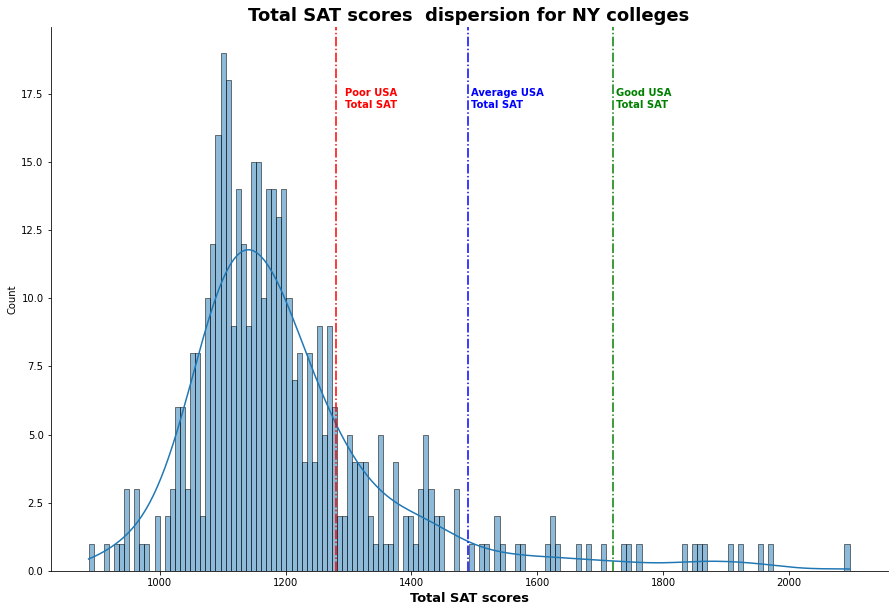

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
f, ax = plt.subplots(figsize=(15, 10))
sns.despine(f)
sns.histplot(x = data["sat_results"]['sat_score'].dropna(),
                     multiple="stack", kde = True, bins = 150)

# Adding  vertical lines for poor -  1 280, average - 1 490 and good - 1 720 total SAT scores
plt.axvline(1280, color='red', linestyle='-.')
plt.axvline(1490, color='blue', linestyle='-.')
plt.axvline(1720, color='green', linestyle='-.')
plt.text(1295,17,'Poor USA\nTotal SAT', color='red', weight = 'bold')
plt.text(1495,17, 'Average USA\nTotal SAT', color='blue', weight = 'bold')
plt.text(1725,17, 'Good USA\nTotal SAT', color='green', weight = 'bold')
plt.title('Total SAT scores  dispersion for NY colleges', fontsize=18, weight = 'bold')
plt.xlabel('Total SAT scores', size=13, weight = 'bold')
plt.show()

Create pivot table and pie plot for SAT gradation: 

In [11]:
# Add column "stat_cat" to dataframe colleges
combined["stat_cat"] = combined.apply(
    lambda row:"Poor and less (SAT <= 1,280]" if row.sat_score <= 1280  
    else ("Poor & Average (1,280 <SAT < 1,490)"
          if 1290 < row.sat_score < 1490 
    else "Average &  Good [1,490 <SAT < 1,720)" 
          if 1490 <= row.sat_score < 1720 
    else "Good  &  Excellent [1,720 <SAT <= 1,930)" 
          if 1720 <= row.sat_score <1930
    else "Excellent [1,930 <= SAT < 2300)" 
          if 1930 <= row.sat_score <2300 else None
    ), axis = 1)

# Output sorted pivot tables
combined.groupby("stat_cat").size().reset_index(name = "number_of").\
sort_values("number_of",ascending=False) 

,stat_cat,number_of
4,"Poor and less (SAT <= 1,280]",286
3,"Poor & Average (1,280 <SAT < 1,490)",49
0,"Average & Good [1,490 <SAT < 1,720)",13
2,"Good & Excellent [1,720 <SAT <= 1,930)",9
1,"Excellent [1,930 <= SAT < 2300)",3


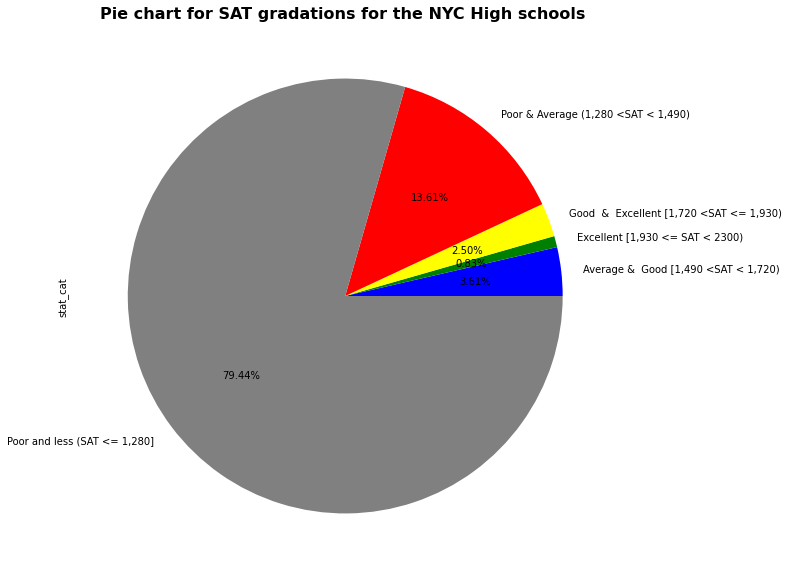

In [12]:
ax, fig = plt.subplots()
colors_p = ("blue", "green","yellow", "red", "grey") 
ax = combined.groupby(["stat_cat"])['stat_cat'].count().\
    plot.pie(autopct='%1.2f%%',figsize = (15, 10), colors = colors_p )
ax.set_title("Pie chart for SAT gradations for the NYC High schools ", fontsize = 16,
            weight = "bold")
plt.show()

**First conclusion:**
We have next share dispersion for NY colleges education levels in 2011 year relative SAT values for Total USA percentile 2011 
* 1. Poor and bellow 1290 - 79.44%
* 2. Between Poor and Average > 1,290 and <1,490 -  13.61%
* 3. Between Average and Good >=1,490 and <1,720 - 3.61
* 4. Good and Excellent  < 1,720 and <=1,930  - 2.50%
* 5. Excellent and above - 0.83%
* As seen from cell[16] only one college from 363 have average SAT scores in to  "Excellent - 2030 and above" category. Average SAT category "Best - 2 310 and above" haven't any college.


## Plotting survey correlations

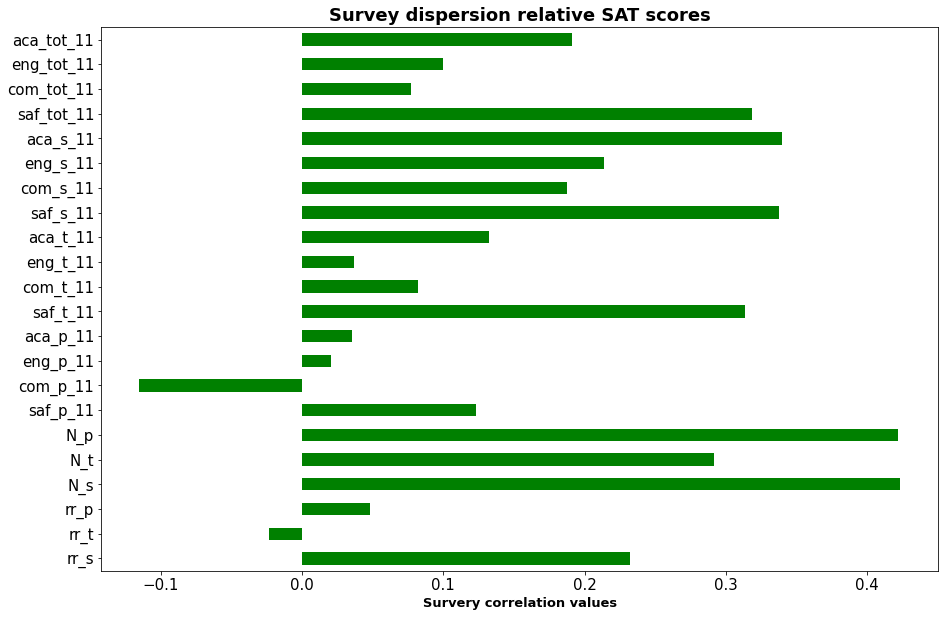

In [13]:
ax = correlations[survey_fields].plot.barh(figsize=(15, 10), 
                                     color='green', 
                                     fontsize=15)
plt.title('Survey dispersion relative SAT scores', fontsize=18, weight = 'bold')
plt.xlabel('Survery correlation values', size=13, weight = 'bold');

Us we see from this plot relative 'sat_score' column:
* **1. These values have moderate positive  linear relationship through a fuzzy-firm linear rule.** 

N_s - Number of student respondents

N_p - Number of parent respondents

saf_t_11 - Safety and Respect total score

saf_s_11 - Safety and Respect score based on student responses

aca_s_11 - Academic expectations score based on student responses

saf_tot_11 - Safety and Respect score based on teacher responses

* **2. These values have a weak positive  linear relationship through a shaky linear rule.** 

rr_s - Student Response Rate

rr_p - Parent Response Rate

N_t- Number of teacher respondents

nr_s - Number of eligible students

nr_t - Number of eligible teachers

nr_p - Number of eligible parents

saf_p_11 - Safety and Respect score based on parent responses

eng_p_11 - Engagement score based on parent responses

aca_p_11 - Academic expectations score based on parent responses

com_t_11 - Communication score based on teacher responses

eng_t_11 - Engagement score based on teacher responses

aca_t_11 - Academic expectations score based on teacher responses

com_s_11 - Communication score based on student responses

eng_s_11 - Engagement score based on student responses

com_tot_11 - Communication total score

eng_tot_11 - Engagement total score

aca_tot_11 - Academic Expectations total score

* **3.  These values have a weak  negative linear relationship through a shaky linear rule.**

com_p_11 - Communication score based on parent responses

rr_t -Teacher Response Rate

**Second conclusion:**

The most of NY Colleges in 2011 year didn't take very good level of  education, hence relations above had moderate and weak positive and negative relationship with total SAT score, because total SAT score in most case is poor or poorest.

## 2. Exploring Safety and total SAT Scores

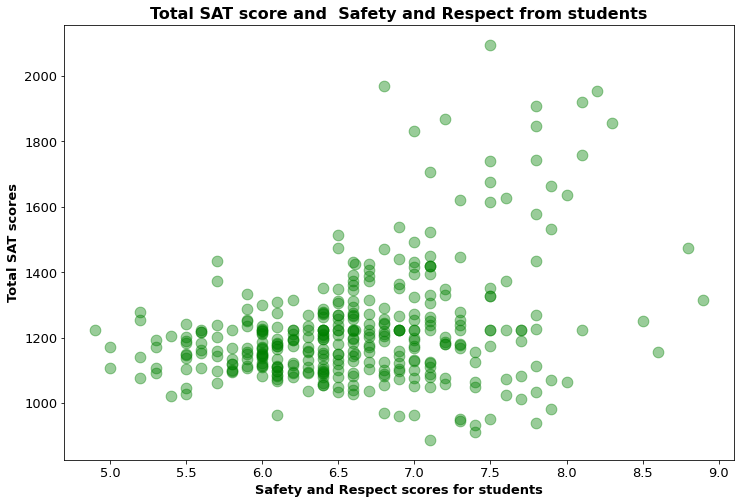

In [14]:
# Plotting 'sat_score' vs. 'saf_s_11'
ax = combined.plot.scatter(x='saf_s_11', y='sat_score', 
                      figsize=(12, 8), color='green',
                      fontsize=13, s=115, alpha=0.4)
plt.title('Total SAT score and  Safety and Respect from students', fontsize=16, weight = 'bold')
plt.xlabel('Safety and Respect scores for students', size=13, weight = 'bold')
plt.ylabel('Total SAT scores', size=13, weight = 'bold')
plt.show()

**Third conclusion:**

We see typical the  moderate positive  linear relationship through a fuzzy-firm linear rule for r = 0.337639

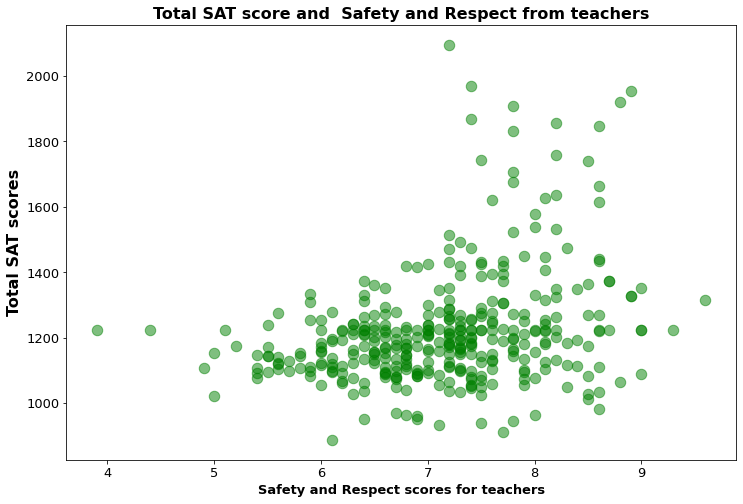

In [15]:
# Plotting 'sat_score' vs. 'saf_t_11'
ax = combined.plot.scatter(x='saf_t_11', y='sat_score', 
                      figsize=(12, 8), color='green',
                      fontsize=13, s=110, alpha=0.5)
plt.title('Total SAT score and  Safety and Respect from teachers', fontsize=16, weight = 'bold')
plt.xlabel('Safety and Respect scores for teachers', size=13, weight = 'bold')
plt.ylabel('Total SAT scores', size=16, weight = 'bold')
plt.show()

**Fourth conclusion:**

We see typical the moderate positive linear relationship through a fuzzy-firm linear rule for r = 0.318753 and almost seem for previous student plot.


### Calculate  safety scores for  each borough of NY
* 1. Student's scores 

In [16]:
combined.groupby('boro').agg(np.mean)['saf_s_11'].sort_values(ascending=False)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

* 2. Teacher's scores 

In [17]:
combined.groupby('boro').agg(np.mean)['saf_t_11'].sort_values(ascending=False)

boro
Queens           7.365625
Manhattan        7.287778
Staten Island    7.210000
Bronx            7.026882
Brooklyn         6.985849
Name: saf_t_11, dtype: float64

**Fifth conclusion:**

Queens ans Manhattan for students and teachers have most scores than others borough. The lowest score for and students and teachers have borough Brooklyn  and Bronx.

## 3. Exploring Race and SAT Scores

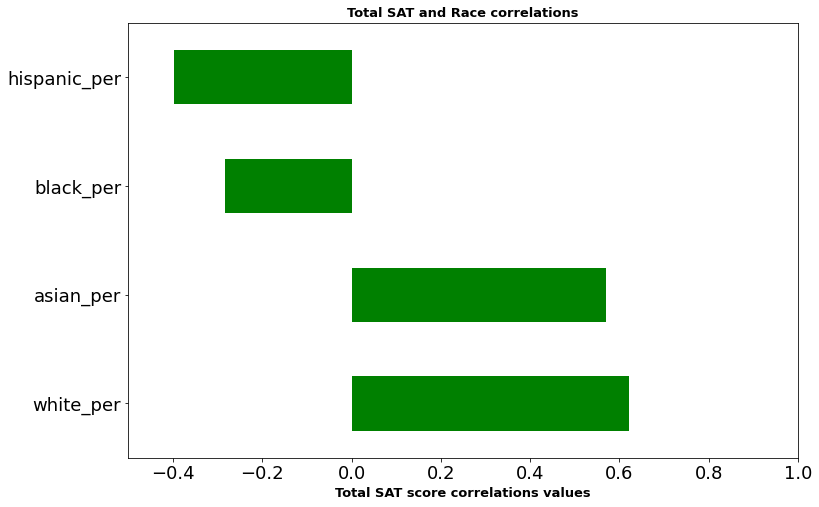

In [18]:
# Define list of races 
races = ['white_per','asian_per', 'black_per','hispanic_per']

# Plotting race correlations vs. SAT scores
correlations[races].plot.barh(figsize=(12, 8), color='green', 
                                              fontsize=18)
plt.title('Total SAT and Race correlations', fontsize=13, weight = 'bold')
plt.xlabel('Total SAT score correlations values', size=13, weight = 'bold')
plt.xlim(-0.5, 1.0);

**Sixth conclusion:**

Us we see asian and white races have a moderate positive  linear relationship through a fuzzy-firm linear rule relative total SAT scores. Latinos and black have  moderate negative linear relationship through a fuzzy-firm linear rule relative total SAT scores. Possible reason - monetary segregation by cost of education or live in not rich of borough NY.

### Explore schools with low SAT scores and high values for hispanic_per and black_per.

Create of scatter plot for Hispanic.

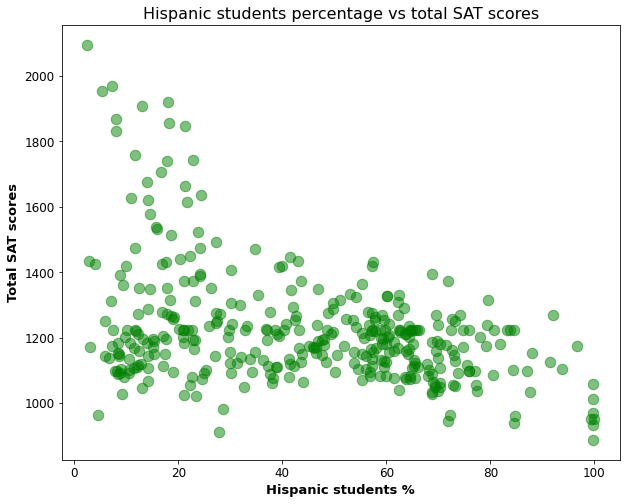

In [19]:
# Plotting 'hispanic_per' vs 'sat_score' vs. 
ax = combined.plot.scatter(x='hispanic_per', y='sat_score', 
                      figsize=(10, 8), color='green',
                      fontsize=12, s=110, alpha=0.5)
plt.title('Hispanic students percentage vs total SAT scores', fontsize=16)
plt.xlabel('Hispanic students %', size=13, weight = 'bold')
plt.ylabel('Total SAT scores', size=13, weight = 'bold');

We see  moderate negative linear relationship through a fuzzy-firm linear rule for value r = -0.396985. Than less percentage Hispanic in school - than higher  total SAT score. 

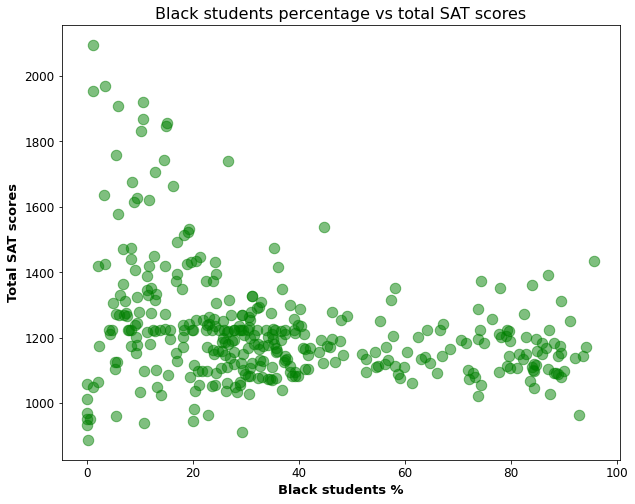

In [20]:
# Plotting 'black_per' vs 'sat_score' vs. 
ax = combined.plot.scatter(x='black_per', y='sat_score', 
                      figsize=(10, 8), color='green',
                      fontsize=12, s=110, alpha=0.5)
plt.title('Black students percentage vs total SAT scores', fontsize=16)
plt.xlabel('Black students %', size=13, weight = 'bold')
plt.ylabel('Total SAT scores', size=13, weight = 'bold');

We see almost seem dispersions for plot of Hispanic above but when 100% students are black average result is higher than Hispanic - may be black student have native English?


### List of schools with more than 95% of Hispanic.

In [21]:
hispanic_over_95 = combined[combined['hispanic_per'] > 95][['school_name', 'sat_score']]
hispanic_over_95

,school_name,sat_score
44,Manhattan Bridges High School,1058.0
82,Washington Heights Expeditionary Learning School,1174.0
89,Gregorio Luperon High School for Science and M...,1014.0
125,Academy for Language and Technology,951.0
141,International School for Liberal Arts,934.0
176,Pan American International High School at Monroe,970.0
253,Multicultural High School,887.0
286,Pan American International High School,951.0


After searching in the Google  it becomes clear these schools teach recently arrived Hispanic immigrant from Latin America with low levels of general education and  with bad knowledge of English.  


### List of schools with less  than 10% of Hispanic and total SAT scores over 1800.

In [22]:
hispanic_less_10_SAT_over_1800 = combined[(combined['hispanic_per'] < 10) 
                                             & (combined['sat_score'] > 1800)][['school_name', 'sat_score']]
hispanic_less_10_SAT_over_1800

,school_name,sat_score
37,Stuyvesant High School,2096.0
151,Bronx High School of Science,1969.0
187,Brooklyn Technical High School,1833.0
327,Queens High School for the Sciences at York Co...,1868.0
356,Staten Island Technical High School,1953.0


After searching in the Google  it becomes clear that these are private right schools for students with  high income levels of parents.

**Seventh conclusion:**
If you parents have high level of income and you have good knowledge of English - you can take good education. 

### 4. Exploring Gender and SAT Scores

As we see above  r for male_per r = -0.112062, for female_per r = 0.112108.
Lets create plot:

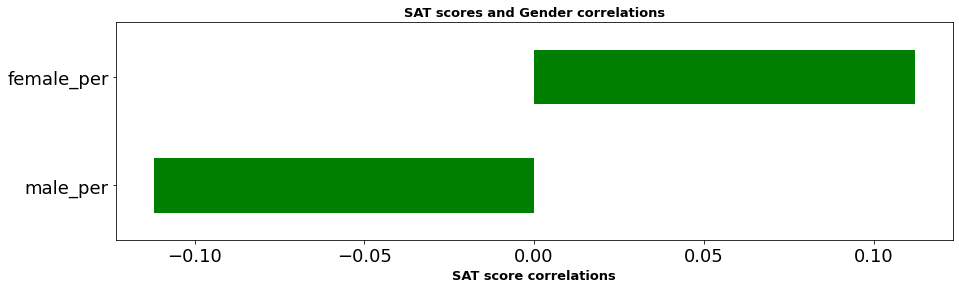

In [23]:
# Creating a list of columns with sex
sex = ['male_per', 'female_per']

# Plotting genders correlations for  SAT score correlations
combined.corr()['sat_score'][sex].plot.barh(figsize=(15, 4), fontsize=18, 
                                            color='green')
plt.title('SAT scores and Gender correlations', fontsize=13, weight = 'bold')
plt.xlabel('SAT score correlations', size=13, weight = 'bold')
plt.show()

In other cases correlation have  weak positive for male and negative for female linear relationship through a shaky linear rule. Probably than female more self-collected and responsible for learning than male.

**Create a scatter plot of female_per vs. sat_score.**

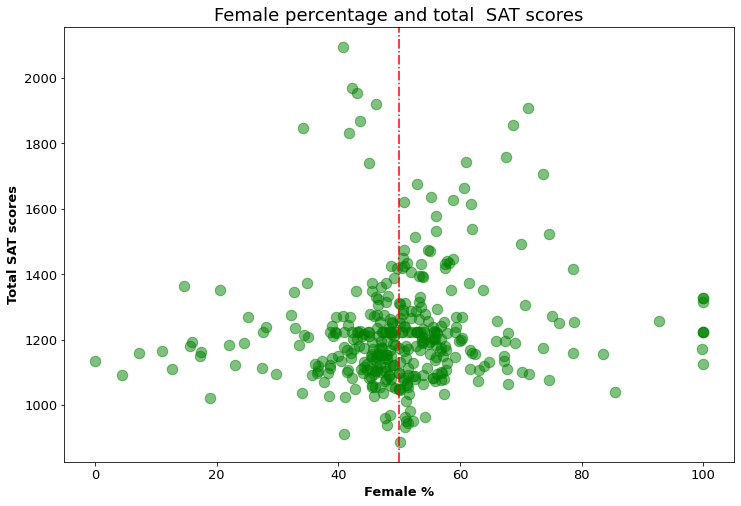

In [24]:
# Plotting   'female_per' and 'sat_score'
combined.plot.scatter(x='female_per', y='sat_score', figsize=(12, 8),
                      color='green', fontsize=13, 
                      s=110, alpha=0.5)
plt.title('Female percentage and total  SAT scores', fontsize=18)
plt.xlabel('Female %', size=13, weight = 'bold')
plt.ylabel('Total SAT scores', size=13, weight = 'bold')

# Adding a one half vertical line
plt.axvline(50, color='red', linestyle='-.')
plt.show()

### Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.

In [25]:
female_over_60_SAT_over_1700 = combined[(combined['female_per'] > 60) 
                                           & (combined['sat_score'] > 1700)]\
                                           [['school_name', 'sat_score', 'female_per']]
female_over_60_SAT_over_1700

,school_name,sat_score,female_per
5,Bard High School Early College,1856.0,68.7
26,Eleanor Roosevelt High School,1758.0,67.5
60,Beacon High School,1744.0,61.0
61,Fiorello H. LaGuardia High School of Music & A...,1707.0,73.6
302,Townsend Harris High School,1910.0,71.1


 Searching in the Google show that these schools where female over 60%    specialized in general humanitarian disciplines  like languages, history, social sciences, literature,  liberals arts, music and etc. 

## 5. Exploring AP Scores vs. SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

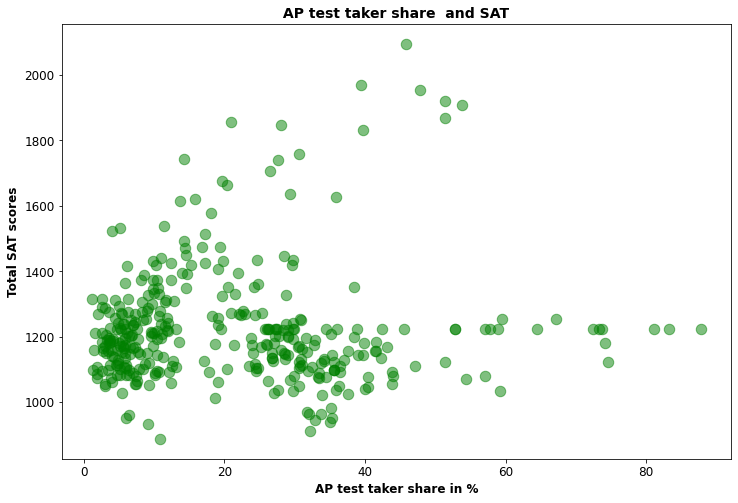

In [26]:
# Insert new columns with  the percentage of students for each school taken an AP exam
combined['ap_share'] = combined['AP Test Takers '] * 100/ combined['total_enrollment']

# Plotting 'sat_score' vs. 'ap_per'
ax = combined.plot.scatter(x='ap_share', y='sat_score', 
                      figsize=(12, 8), color='green',
                      fontsize=12, s=110, alpha=0.5)
plt.title(' AP test taker share  and SAT ', fontsize=14, weight = 'bold')
plt.xlabel('AP test taker share in %', size=12, weight = 'bold')
plt.ylabel('Total SAT scores', size=12, weight = 'bold');

Us we remember for AP Test Takers r = 0.523140, what mean moderate positive linear relationship through a fuzzy-firm linear rule. As we see plot contains  two regions - left  square has positive correlations above point x = 20, y = 1200 and right region above x = 20 and y <= 1300 hasn't any  correlations. Possible reasons - using fillna method in the cell [7] for non existing values.   

In [27]:
# Rerun the code in the  cell [7] for combined_test, without filling missing values
combined_v2 = data['sat_results']
combined_v2 = combined_v2.merge(data['ap_2010'], on='DBN', how='left')
combined_v2 = combined_v2.merge(data['graduation'], on='DBN', how='left')
merge_list_v2 = ['class_size', 'demographics', 'survey', 'hs_directory']
for i in merge_list_v2:
    combined_v2 = combined_v2.merge(data[i], on='DBN', how='inner')
combined_v2

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,32K545,EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK,88,384.0,409.0,361.0,1154.0,EBC-HS FOR PUB SERVICE (BUSH),47.0,64.0,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1155 Dekalb Avenue\nBrooklyn, NY 11221\n(40.69...",40.694482,-73.929154
359,32K549,BUSHWICK SCHOOL FOR SOCIAL JUSTICE,75,348.0,353.0,334.0,1035.0,NaN,NaN,NaN,...,Then to District 32 students or residents,Then to Brooklyn students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816
360,32K552,ACADEMY OF URBAN PLANNING,67,342.0,364.0,354.0,1060.0,Academy of Urban Planning,76.0,100.0,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816
361,32K554,ALL CITY LEADERSHIP SECONDARY SCHOOL,39,428.0,465.0,422.0,1315.0,All City Leadership Secondary School,7.0,8.0,...,Then to New York City residents who attend an ...,"Then to Districts 24, 30 and 32 students or re...",Then to Brooklyn students or residents,Then to New York City residents,NaN,NaN,NaN,"321 Palmetto Street\nBrooklyn, NY 11237\n(40.6...",40.697408,-73.913153


Recalculate correlation for combined_v2 dataset

In [28]:
correlations_v2 = combined_v2.corr()
correlations_v2 = correlations_v2["sat_score"]
# Print all values for correlations["sat_score"]
print(correlations_v2)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.619152
                                     ...   
zip                               -0.067080
total_students                     0.411785
number_programs                    0.118241
lat                               -0.124166
lon                               -0.137163
Name: sat_score, Length: 63, dtype: float64


As we see, r for AP Test Takers rising from   0.523140 to 0.619152 or + 18.35%.
Create plot for real data in combined_v2 dataset:

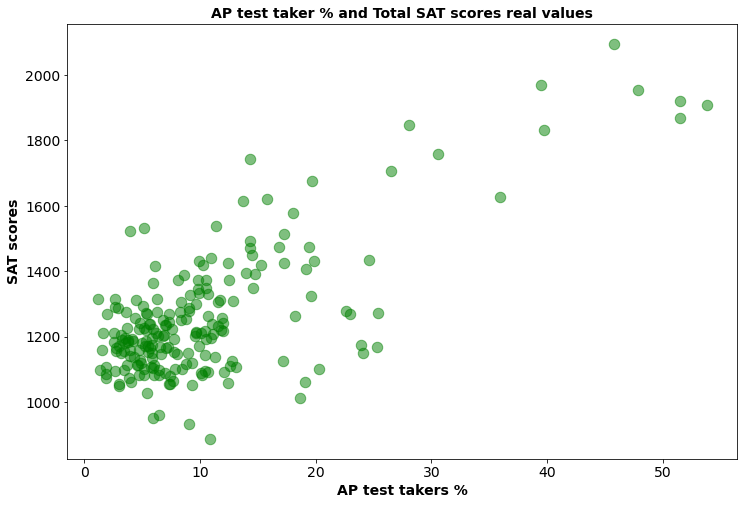

In [29]:
# Rerun the code cell [24] for combined_test
combined_v2['ap_per'] = combined_v2['AP Test Takers '] * 100/ combined_v2['total_enrollment']
ax = combined_v2.plot.scatter(x='ap_per', y='sat_score', 
                      figsize=(12, 8), color='green',
                      fontsize=14, s=110,  alpha=0.5)
plt.title('AP test taker % and Total SAT scores real values', fontsize=14, weight = 'bold')
plt.xlabel('AP test takers %', size=14, weight = 'bold')
plt.ylabel('SAT scores', size=14, weight = 'bold');

I assume that  student incoming in NY Colleges with education level high average equal or more than  Good Total SAT USA score  = 1720 taken AP test for getting in future possible benefits like  free or part  pay of  learning in private colleges or incoming to the  public colleges with education level Good Total SAT USA score.
When colleges have  education level lower than  Good Total SAT USA score = 1720 quantity of takers AP test falls - may be  these colleges have free pay learning and you get diploma with 'trash' score rating and skills enough for writing phrase "We are not slaves, slaves  are not we". 

## 6. Explore correlations  free and reduced lunch, class size and Total SAT Scores

Us we remember  for frl_percent r = -0.722225 and has  strong negative linear relationship through a firm linear rule  let's create plot for free and reduced lunch and Total SAT Scores:

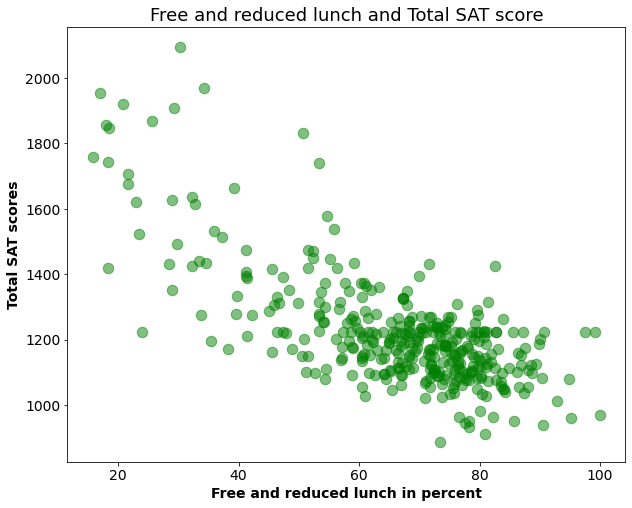

In [30]:
# Plotting 'sat_score' vs. 'frl_percent'
ax = combined.plot.scatter(x='frl_percent', y='sat_score', 
                      figsize=(10, 8), color='green',
                      fontsize=14, s=110, alpha=0.5)
plt.title('Free and reduced lunch and Total SAT score', fontsize=18)
plt.xlabel('Free and reduced lunch in percent', size=14, weight = 'bold')
plt.ylabel('Total SAT scores', size=14, weight = 'bold');

On other hand we see the most of students in  colleges with  education level Poor USA  Total SAT or low haven't enough money for lunch in college. By other hand  we see that free lunches are in the colleges with level Good USA total SAT that show that 20 - 37% percents students in these colleges  come from poor families and possible learn free / free part  pay using high score of AP test.

Create plot Class Size and SAT Scores:

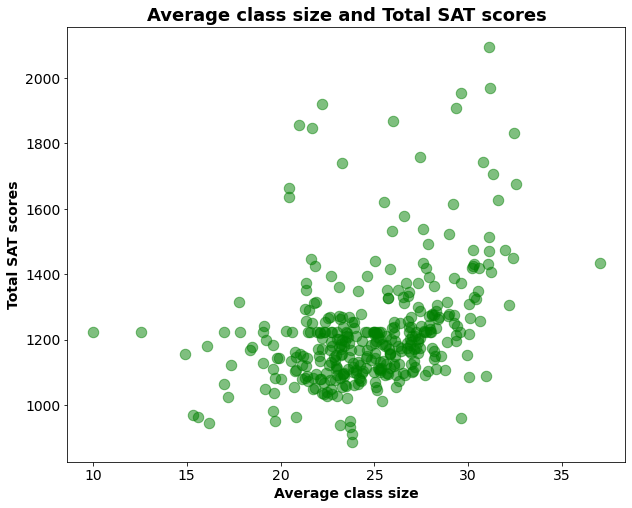

In [31]:
ax = combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score', 
                      figsize=(10, 8), color='green',
                      fontsize=14, s=110, alpha=0.5)
plt.title('Average class size and Total SAT scores', fontsize=18,  weight = 'bold')
plt.xlabel('Average class size', size=14, weight = 'bold')
plt.ylabel('Total SAT scores', size=14, weight = 'bold');

We remember that for AVERAGE CLASS SIZE r =  0.381014, and has moderate positive  linear relationship through a fuzzy-firm linear rule. As we see class size has  less impact for total SAT Scores - values SAT total scores for  class over 30 students variate from less 1 000 score and more 2 000 scores.

## Summary conclusion

* I shocked next  share dispersion for NY colleges education levels in 2011 year relative SAT score  values for Total USA percentile 2011 because NY is one of the richest and most populous cities in the USA:
* 1. Poor and bellow 1290 - 79.44%
* 2. Between Poor and Average > 1,290 and <1,490 -  13.61%
* 3. Between Average and Good >=1,490 and <1,720 - 3.61
* 4. Good and Excellent  < 1,720 and <=1,930  - 2.50%
* 5. Excellent and above - 0.83%

**I see here great social segregation among  the population by income**


* 2. "Society does not consist of individuals, but expresses the sum of interrelations, the relations within which these individuals stand." Karl Marx <a href="https://en.wikipedia.org/wiki/Historical_materialism" target="_blank">Grundrisse,</a> 1858 - us we see from this research society is a major factor correlation with high total SAT scores. If your English is native or fluently, you live in elite borough of NY and you parents have high income and you have normal essential education getting in good schools - it doesn't matter who you are - black, male or female, Asian, Muslim, Hispanic, Jude or white - if you will self-collected and responsible, will not lazy -  you get good education in the good colleges.

Created on Mar 2, 2021

@author: Vadim Maklakov, used some ideas from public Internet resources.

© 3-clause BSD License

Software environment: 

Debian 10

Python 3.8.7

required next preinstalled python modules: 

matplotlib
 
numpy 

pandas 

seaborn